In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import os
import sys

from itertools import count
from IPython.display import display, clear_output
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch import nn

from tqdm import tqdm
import pandas as pd

sys.path.append('home/brysongray/tractogrpahy/')
from agent.sac_tracker import Actor, Critic
from environments.sac_tracking_env import Environment
from memory.buffer import ReplayBuffer, PrioritizedReplayBuffer
import tracking_interface

DEVICE = "cuda"
dtype = torch.float32

date = datetime.now().strftime("%m-%d-%y")


In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv3d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm3d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv3d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm3d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 3):
        super(ResNet, self).__init__()
        self.infilters = 64
        # self.conv1 = nn.Sequential(
        #                 nn.Conv3d(3, 64, kernel_size=3, stride=2, padding=1),
        #                 nn.BatchNorm3d(64),
        #                 nn.ReLU())
        self.conv1 = nn.Sequential(
                        nn.Conv3d(3, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm3d(64),
                        nn.ReLU())
        # self.maxpool = nn.MaxPool3d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 1)
        # self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool3d(4, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, filters, blocks, stride=1):
        downsample = None
        if stride != 1 or self.infilters != filters:

            downsample = nn.Sequential(
                nn.Conv3d(self.infilters, filters, kernel_size=1, stride=stride),
                nn.BatchNorm3d(filters),
            )
        layers = []
        layers.append(block(self.infilters, filters, stride, downsample))
        self.infilters = filters
        for i in range(1, blocks):
            layers.append(block(self.infilters, filters))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        # x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)

        return x

class Net(torch.nn.Module):
    ''' Takes in state and returns gaussian mean and logvar (in 2d).
    
    Takes in a 21x21 image, 
    typically this is 1 channel of an "image"
    1 channel is a canvas we are drawing on
    (sometimes) 2 channel are the x and y components of our action
    
    Output will be either 3 numbers (policy net), meanx, meany, logvar (isotropic)
    Or for a qnet, it will be 1 number (expected future reward)
    
    The network is 3 convs and batchnorms, followed by 2 linear layers
    '''
    def __init__(self,chin=4,ch0=16,chout=4):
        super().__init__()        
        k = 3
        p = (k-1)//2
        s = 2
        self.c0 = torch.nn.Conv3d(chin,ch0,k,s,p)
        self.b0 = torch.nn.BatchNorm3d(ch0)
        self.c1 = torch.nn.Conv3d(ch0,2*ch0,k,s,p)
        self.b1 = torch.nn.BatchNorm3d(2*ch0)
        self.c2 = torch.nn.Conv3d(2*ch0,4*ch0,k,s,p)
        self.b2 = torch.nn.BatchNorm3d(4*ch0)
        self.l0 = torch.nn.Linear(5**3*64,64)        
        self.l1 = torch.nn.Linear(64,chout)
    def forward(self,x):
        x = self.c0(x)
        x = self.b0(x)
        x = torch.relu(x)
        
        x = self.c1(x)
        x = self.b1(x)
        x = torch.relu(x)
        
        x = self.c2(x)
        x = self.b2(x)
        x = torch.relu(x)
        
        
        x = self.l0(x.reshape(x.shape[0],-1))
        x = torch.relu(x)
        
        x = self.l1(x)
        return x


def sample_from_output(out, random=False):    
    '''
    A function to differentiably sample
    '''
    
    mean = out[:,:3] # component 0, 1 and 2
    logvar = out[:,3:] # logvar component 3
    # I want the mean and logvar to be squashed
    # note it would probably be better to not squash components independently
    # better to squash them by their vector norm
    # but it's not a big deal
    meannorm = torch.linalg.norm(mean, dim=-1, keepdim=True)
    meannorm_ = torch.tanh(meannorm)*10 # maximum of 10
    mean = mean * meannorm_/(meannorm + torch.finfo(torch.float).eps)
    logvar = torch.tanh(logvar)*3 + 1 # no very low variance (std is order of 1 pixel) 
    # between 0 and 4
    # std between 1 and 7.4
    # sample = (torch.randn(out.shape[0],3).to(device=out.device)*torch.exp(logvar*0.5) + mean)
    # sample = sample * torch.tensor([[0,1,1]], device=out.device)
    # direction_dist = torch.distributions.MultivariateNormal(mean[:,:2], torch.exp(logvar)[:,None]*torch.eye(2, device=DEVICE)[None])# for paths constrained to a 2d slice
    direction_dist = torch.distributions.MultivariateNormal(mean[:,:3], torch.exp(logvar)[:,None]*torch.eye(3, device=DEVICE)[None])

    return direction_dist


def update_Q(actor, Q1, Q1_target, Q2, Q2_target,
             obs, actions, rewards, next_obs, dones,
             Q1_optimizer, Q2_optimizer, gamma,
             log_alpha, weights=None):

    # Perform one step of the optimization on the Q networks.
    # compute targets
    with torch.no_grad():
        # sample next actions from the current policy
        actor_out = actor(next_obs) # set steps_done to start_steps so that this samples from the current policy
        direction_dist = sample_from_output(actor_out)
        next_directions = direction_dist.rsample()
        logprobs = direction_dist.log_prob(next_directions)
        # next_directions = torch.concatenate((torch.zeros(next_directions.shape[0],1, device=DEVICE), next_directions), dim=1) # for paths constrained to a 2d slice
        # get target q-values
        next_states = torch.concatenate((next_obs, torch.ones((next_obs.shape[0], 1, next_obs.shape[2], next_obs.shape[3], next_obs.shape[4]), 
                                            device=DEVICE)*next_directions[:,:,None,None,None]), dim=1)
        Q1_target_vals = Q1_target(next_states) # vector of q-values for each choice
        Q2_target_vals = Q2_target(next_states)
        targets = rewards + gamma * torch.logical_not(dones) * (torch.minimum(Q1_target_vals, Q2_target_vals) - log_alpha.exp() * logprobs[:,None])
    # compute q-values to compare against targets
    current_state = torch.concatenate((obs, 
                        torch.ones((obs.shape[0], 1, obs.shape[2], obs.shape[3], obs.shape[4]), 
                                    device=DEVICE)*actions[:,:,None,None,None]), dim=1)
    
    if weights is None:
        weights = torch.ones_like(targets, device=DEVICE)
    
    if weights.device != DEVICE:
        weights = weights.to(device=DEVICE)

    Q1_vals = Q1(current_state)
    Q1_td_error = torch.abs(Q1_vals - targets).detach()
    Q1_loss = torch.mean((Q1_vals - targets)**2 * weights)
    Q1_optimizer.zero_grad()
    Q1_loss.backward()
    Q1_optimizer.step()

    Q2_vals = Q2(current_state)
    Q2_td_error = torch.abs(Q2_vals - targets).detach()
    Q2_loss = torch.mean((Q2_vals - targets)**2 * weights)
    Q2_optimizer.zero_grad()
    Q2_loss.backward()
    Q2_optimizer.step()

    td_error = torch.maximum(Q1_td_error, Q2_td_error).squeeze()
    return td_error


def show_state(env, returns, rewards, policy_loss, fig):
    ax = fig.axes
    clear_output(wait=True)
    for x in ax:
        x.cla()

    img = env.img.data[:3].clone().detach().cpu()
    path = env.img.data[3].clone().detach().cpu()
    mask = torch.where(env.section_labels.data[0].clone().detach().cpu() > 0, 1.0, 0.0)
    true_density = env.true_density.data[0].detach().clone().cpu()
    for j in range(3):
        ax[j].imshow(img.permute(1,2,3,0).amax(j))
        ax[j].imshow(path.amax(j), cmap='gray', alpha=0.8)

    for j in range(3):
        toshow = torch.stack((true_density.amax(j), path.amax(j), mask.amax(j)), dim=-1)
        ax[j+3].imshow(toshow)
        # ax[j+3].imshow(true_density.amax(j), cmap='Reds')
        # ax[j+3].imshow(path.amax(j), cmap='Greens', alpha=0.5)
        # ax[j+3].imshow(mask.amax(j), cmap='Blues', alpha=0.5)


    ax[6].plot(rewards)
    ax[6].set_title("ep rewards")

    ax[7].plot(returns)
    ax[7].set_title("ep returns")
    
    ax[8].plot(policy_loss)
    ax[8].set_title("policy loss")

    display(fig)
    # clear_output(wait = True)
    # plt.pause(0.1)
    
    return


In [26]:
# f = open('/home/brysongray/tractography/neuron_trx/configs/sac_config_8-9-24.json')
# f = open("/home/brysongray/tractography/neuron_trx/configs/config_astro-1.json")
f = open("/home/brysongray/tractography/neuron_trx/configs/config_3d_no_artifacts_b-0.json")
args = json.load(f)

img_path = args["img_path"]
outdir = args["outdir"]
name = args["name"]
seeds = args["seeds"] if "seeds" in args else None
model = args["model"] if "model" in args else None
n_seeds = args["n_seeds"] if "n_seeds" in args else 1
step_size = args["step_size"] if "step_size" in args else 1.0
step_width = args["step_width"] if "step_width" in args else 1.0
batch_size = args["batchsize"] if "batchsize" in args else 256
gamma = args["gamma"] if "gamma" in args else 0.99
tau = args["tau"] if "tau" in args else 0.005
lr = args["lr"] if "lr" in args else 0.001
alpha = args["alpha"] if "alpha" in args else 1.0
beta = args["beta"] if "beta" in args else 1e-3
friction = args["friction"] if "friction" in args else 1e-4
num_episodes = args["num_episodes"] if "num_episodes" in args else 100
pixelsize = args["pixelsize"] if "pixelsize" in args else [1.0, 1.0, 1.0]
patch_radius = 17

In [30]:
# classifier = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=1)
# classifier = classifier.to(device=DEVICE, dtype=dtype)
# # classifier_state_dict = torch.load("/home/brysongray/tractography/pretrained_models/resnet_classifier_11-14-24_checkpoint-0.pt", weights_only=True)
# # classifier_state_dict = torch.load("/home/brysongray/tractography/pretrained_models/resnet_classifier_11-25-24_checkpoint-2.pt", weights_only=True)
# # classifier_state_dict = torch.load("/home/brysongray/tractography/pretrained_models/resnet_classifier_11-22-24_checkpoint-5.pt", weights_only=True)
# # classifier_state_dict = torch.load("/home/brysongray/tractography/pretrained_models/resnet_classifier_12-02-24_checkpoint-10.pt", weights_only=True)
# # classifier_state_dict = torch.load("/home/brysongray/tractography/pretrained_models/resnet_classifier_12-03-24_checkpoint-99.pt", weights_only=True)
# classifier_state_dict = torch.load("/home/brysongray/tractography/pretrained_models/resnet_classifier_01-07-25_checkpoint-42.pt", weights_only=True)

# classifier.load_state_dict(classifier_state_dict)
# classifier.eval()

# instantiate environment
env = Environment(img_path,
                  radius=patch_radius,
                  seeds=seeds,
                  step_size=step_size,
                  step_width=step_width,
                  max_len=10000,
                  alpha=alpha,
                  beta=beta,
                  friction=friction,
                  branching=False,
                  classifier=None)

Loading image /home/brysongray/tractography/data/training_data/simulated_neurons/3d_no_artifacts_b-0/img_94.pt


In [31]:
in_channels = 4
input_size = 2*patch_radius+1
init_temperature = 0.005
# n_filters = 16
# start_steps = 1

# actor = Actor(in_channels, input_size, n_filters).to(DEVICE)
# Q = Critic(in_channels, input_size, n_filters).to(DEVICE)
# Q_target = Critic(in_channels, input_size, n_filters).to(DEVICE)

# Q_target.load_state_dict(Q.state_dict())

actor = Net(chin=in_channels, chout=4)
actor = actor.to(device=DEVICE,dtype=dtype)

Q1 = Net(chin=in_channels+3,chout=1)
Q1 = Q1.to(device=DEVICE,dtype=dtype)
Q2 = Net(chin=in_channels+3,chout=1)
Q2 = Q2.to(device=DEVICE,dtype=dtype)
Q1_target = Net(chin=7,chout=1)
Q1_target = Q1_target.to(device=DEVICE,dtype=dtype)
Q2_target = Net(chin=7,chout=1)
Q2_target = Q2_target.to(device=DEVICE,dtype=dtype)

# pretrained_state_dicts = torch.load("/home/brysongray/tractography/outputs_test/test_10-1-2024_3d_no_branch/model_state_dicts_10-1_3d_no_branch.pt", weights_only=True)
# pretrained_state_dicts = torch.load("/home/brysongray/tractography/outputs_test/model_state_dicts_11-14-2024_with_branching.pt", weights_only=True)
# pretrained_state_dicts = torch.load("/home/brysongray/tractography/outputs_test/model_state_dicts_neurom_dataset_1_11-26-24.pt", weights_only=True)
# pretrained_state_dicts = torch.load("/home/brysongray/tractography/outputs_test/model_state_dicts_neurom_dataset_1_12-12-24.pt", weights_only=True)
# actor.load_state_dict(pretrained_state_dicts["policy_state_dict"])
# Q1.load_state_dict(pretrained_state_dicts["Q1_state_dict"])
# Q2.load_state_dict(pretrained_state_dicts["Q2_state_dict"])

Q1_target.load_state_dict(Q1.state_dict())
Q2_target.load_state_dict(Q2.state_dict())

log_alpha = torch.tensor(np.log(init_temperature)).to(DEVICE)
log_alpha.requires_grad = True
# target_entropy = 3.0
target_entropy = 0.0

Q1_optimizer = optim.AdamW(Q1.parameters(), lr=lr)
Q2_optimizer = optim.AdamW(Q2.parameters(), lr=lr)
actor_optimizer = optim.AdamW(actor.parameters(), lr=lr)
log_alpha_optimizer = torch.optim.Adam([log_alpha], lr=lr)

criterion = torch.nn.MSELoss()
memory = PrioritizedReplayBuffer(100000, obs_shape=(in_channels,input_size,input_size,input_size), action_shape=(3,), alpha=0.8)
# memory = ReplayBuffer(10000, obs_shape=(in_channels,input_size,input_size,input_size), action_shape=(3,))

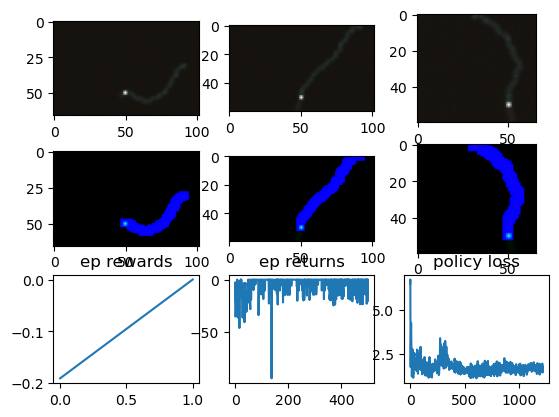

100%|██████████| 500/500 [20:01<00:00,  2.40s/it]

num branches: 1
Loading image /home/brysongray/tractography/data/training_data/simulated_neurons/3d_no_artifacts_b-0/img_94.pt


<Figure size 640x480 with 0 Axes>

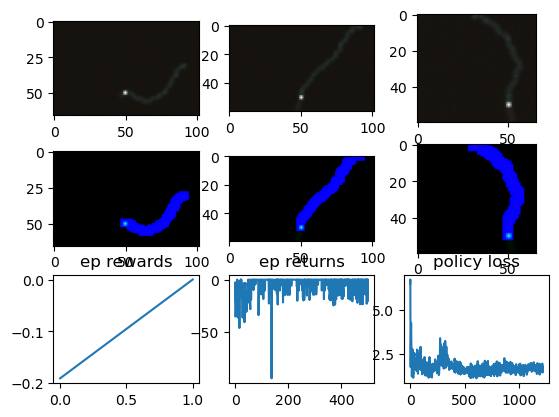

In [32]:
# train
train = True
save_snapshots = False
collect_annotations = False
classifier_annotations_outdir = f"/home/brysongray/tractography/neuron_trx/training_data/branch_classifier_{name}_{date}/"
if not os.path.exists(classifier_annotations_outdir):
    os.makedirs(classifier_annotations_outdir)
    os.mkdir(os.path.join(classifier_annotations_outdir, "observations"))

update_after = 256

steps_done = 0
updates_per_step = 1
update_every = 1
num_updates = 0
policy_loss = []
ep_returns = []
classifier_annotations = {}

# Train the Network
fig1, ax = plt.subplots(3,3, figure=plt.figure(num=1))

plt.ion()
for ep in tqdm(range(num_episodes)):
    coverages = []
    trial_returns = []
    labeled_neurons = []
    for trial in range(1):
        obs = env.get_state()
        ep_return = 0
        ep_rewards = []
        for t in count():

            actor.eval()
            if train and steps_done < update_after:
                action = torch.randn(3).to(DEVICE)*3
                # action = action * torch.tensor([0,1,1], device=DEVICE) # for paths constrained to a 2d slice
            else:
                actor_out = actor(obs).detach()
                direction_dist = sample_from_output(actor_out)
                action = direction_dist.rsample()[0]
                # action = direction_dist.rsample()
                # action = torch.concatenate((torch.tensor([0.0], device=DEVICE), action[0])) # for paths constrained to a 2d slice
                
            steps_done += 1
            # take step, get observation and reward, and move index to next streamline
            path_id = env.head_id
            next_obs, reward, terminated = env.step(action)

            if collect_annotations:
                if path_id < len(env.paths):
                    position = torch.round(env.paths[path_id][-1]).to(int).cpu()
                    target = env.mask[0][*position]
                    fname = f"obs_{steps_done}.pt"
                    torch.save(next_obs, os.path.join(os.path.join(classifier_annotations_outdir, "observations"), fname))
                    classifier_annotations[fname] = target.item()

            ep_return += reward.cpu().item()
            ep_rewards.append(reward.cpu().item())

            if train:
                # Store the transition in memory
                memory.push(obs.cpu(), action.cpu(), next_obs.cpu(), reward.cpu(), terminated)
                
                if steps_done >= update_after:
                    if steps_done % update_every == 0:
                        # Perform updates once there is sufficient transitions saved.
                        actor.train()
                        for j in range(updates_per_step):
                            num_updates += 1
                            if isinstance(memory, ReplayBuffer):
                                obs, actions, next_obs, rewards, dones = memory.sample(batch_size)
                                td_error = update_Q(actor, Q1, Q1_target, Q2, Q2_target,
                                                    obs, actions, rewards, next_obs, dones,
                                                    Q1_optimizer, Q2_optimizer, gamma,
                                                    log_alpha, weights=None)
                            elif isinstance(memory, PrioritizedReplayBuffer):
                                obs, actions, next_obs, rewards, dones, weights, tree_idxs = memory.sample(batch_size)
                                td_error = update_Q(actor, Q1, Q1_target, Q2, Q2_target,
                                                    obs, actions, rewards, next_obs, dones,
                                                    Q1_optimizer, Q2_optimizer, gamma,
                                                    log_alpha, weights=weights)
                                memory.update_priorities(tree_idxs, td_error.cpu().numpy())                    
                            else:
                                raise RuntimeError("Unknown memory buffer")
                                
                            # Perform one step of optimization on the policy network
                            # sample actions from policy
                            actor_out = actor(obs)
                            direction_dist = sample_from_output(actor_out, random=False)
                            directions = direction_dist.rsample()
                            logprobs = direction_dist.log_prob(directions)
                            # directions = torch.concatenate((torch.zeros(directions.shape[0],1, device=DEVICE), directions), dim=1) # for paths constrained to a 2d slice

                            # get expected Q-vals
                            current_state = torch.concatenate((obs, torch.ones((obs.shape[0], 1, obs.shape[2], obs.shape[3], obs.shape[4]),device=DEVICE)*directions[:,:,None,None,None]), dim=1)
                            Q1_vals = Q1(current_state)[:,0]
                            Q2_vals = Q2(current_state)[:,0]
                            # entropy regularized Q values
                            loss = -torch.mean(torch.minimum(Q1_vals, Q2_vals) - log_alpha.exp().detach() * logprobs[:,None]) # The loss function is multiplied by -1 to do gradient ascent instead of decent.
                            policy_loss.append(loss.item())
                            actor_optimizer.zero_grad()
                            loss.backward()
                            actor_optimizer.step()

                            # update target networks
                            for Q,Q_target in zip([Q1, Q2], [Q1_target, Q2_target]):
                                Q_state_dict = Q.state_dict()
                                Q_target_state_dict = Q_target.state_dict()
                                for key in Q_state_dict:
                                    Q_target_state_dict[key] = Q_state_dict[key]*tau + Q_target_state_dict[key]*(1-tau)
                                Q_target.load_state_dict(Q_target_state_dict)

                            log_alpha_optimizer.zero_grad()
                            alpha_loss = (log_alpha.exp() * (-logprobs - target_entropy).detach()).mean()
                            alpha_loss.backward()
                            log_alpha_optimizer.step()
                    
            if terminated:
                if save_snapshots:
                    labeled_neuron = env.img.data[3].detach().cpu() > 0.3 #np.exp(-0.5)
                    true_neuron = env.true_density.data[0].detach().cpu() > 0.94
                    TP = torch.sum(torch.logical_and(labeled_neuron, true_neuron))
                    tot = torch.sum(true_neuron)
                    coverages.append(TP/tot)
                    labeled_neurons.append(env.img.data[3].detach().clone().cpu())
                    trial_returns.append(ep_return)
                
                ep_returns.append(ep_return)
                show_state(env, ep_returns, ep_rewards, policy_loss, fig1)
                print(f"num branches: {len(env.finished_paths)}")
                env.reset(move_to_next=False)
                break
        
            # if not terminated, move to the next state
            obs = env.get_state() # the head of the next streamline

    if collect_annotations:
        df = pd.DataFrame.from_dict(classifier_annotations, orient="index")
        df.to_csv(os.path.join(classifier_annotations_outdir, f"branch_classifier_{name}_{date}_annotations.csv"))
    
    if save_snapshots:
        value, index = torch.max(torch.stack(coverages), dim=0)
        coverage = value.item()
        index = int(index)
        best_return = torch.tensor(trial_returns)[index].item()
        labeled_neuron = labeled_neurons[index]
        paths_dir = os.path.join(outdir, f"episode_snapshots_{name}_{date}_no_branch_v1/")
        if not os.path.exists(paths_dir):
            os.makedirs(paths_dir)

        to_save = {"labeled_neuron": labeled_neuron, "true_neuron": env.true_density.data[0].detach().clone().cpu(), "coverage": coverage, "return": best_return}
        # to_save = {"labeled_neuron": env.finished_paths, "true_neuron": env.true_density.data[0], "global_recall": global_recall, "return": ep_return}
        torch.save(to_save, os.path.join(paths_dir, f"ep_snapshot_{ep}.pt"))

    env.reset()
    


if train:
    # save model
    model_dicts = {"policy_state_dict": actor.state_dict(),
                "Q1_state_dict": Q1_target.state_dict(),
                "Q2_state_dict": Q2_target.state_dict(),}
    torch.save(model_dicts, os.path.join(outdir, f"model_state_dicts_{name}_{date}.pt"))

if collect_annotations:
    # save annotations
    df = pd.DataFrame.from_dict(classifier_annotations, orient="index")
    df.to_csv(os.path.join(classifier_annotations_outdir, f"branch_classifier_{name}_{date}_annotations.csv"))
    # split into test and training data
    data_permutation = torch.randperm(len(classifier_annotations))
    test_idxs = data_permutation[:len(data_permutation)//5].tolist()
    training_idxs = data_permutation[len(data_permutation)//5:].tolist()
    training_annotations = {list(classifier_annotations)[i]: list(classifier_annotations.values())[i] for i in training_idxs}
    test_annotations = {list(classifier_annotations)[i]: list(classifier_annotations.values())[i] for i in test_idxs}
    # save
    df = pd.DataFrame.from_dict(training_annotations, orient="index")
    df.to_csv(os.path.join(classifier_annotations_outdir, f"branch_classifier_{name}_{date}_training_annotations.csv"))
    df = pd.DataFrame.from_dict(test_annotations, orient="index")
    df.to_csv(os.path.join(classifier_annotations_outdir, f"branch_classifier_{name}_{date}_test_annotations.csv"))


In [8]:
# save model
model_dicts = {"policy_state_dict": actor.state_dict(),
            "Q1_state_dict": Q1_target.state_dict(),
            "Q2_state_dict": Q2_target.state_dict(),}
torch.save(model_dicts, os.path.join(outdir, f"model_state_dicts_{name}_{date}.pt"))

# Test

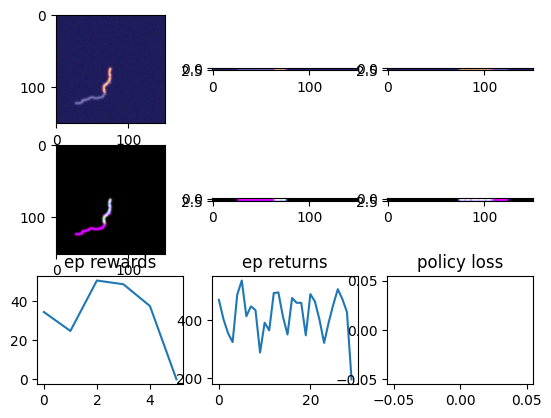

100%|██████████| 30/30 [00:09<00:00,  3.29it/s]


<Figure size 640x480 with 0 Axes>

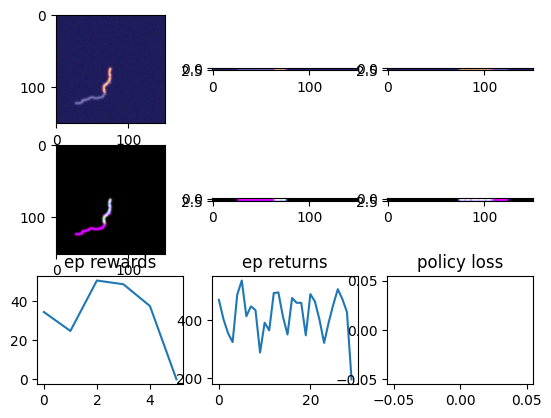

In [61]:
# instantiate environment
env = Environment(img_dir,
                  radius=patch_radius,
                  seeds=seeds,
                  step_size=step_size,
                  step_width=step_width,
                  max_len=150,
                  alpha=alpha,
                  beta=beta,
                  friction=friction,
                  branching=False,
                  classifier=classifier)

# test
episodes = 30

steps_done = 0
policy_loss = []
ep_returns = []

# Train the Network
fig, ax = plt.subplots(3,3, figure=plt.figure(num=1))

plt.ion()
for i in tqdm(range(episodes)):
    obs = env.get_state()
    ep_return = 0
    ep_rewards = []
    for t in count():

        actor.eval()
        actor_out = actor(obs).detach()
        direction_dist = sample_from_output(actor_out)
        action = direction_dist.rsample()
        action = torch.concatenate((torch.tensor([0.0], device=DEVICE), action[0]))
            
        steps_done += 1
        # take step, get observation and reward, and move index to next streamline
        next_obs, reward, terminated = env.step(action)

        ep_return += reward.cpu().item()
        ep_rewards.append(reward.cpu().item())
        
        if terminated:
            ep_returns.append(ep_return)
            show_state(env, ep_returns, ep_rewards, policy_loss, fig)
            env.reset()
            break

        # if not terminated, move to the next state
        obs = env.get_state() # the head of the next streamline